# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
  1
  1
  1
  1
  1
 -1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
  1
 -1
  1

### We create a function to visualize the data

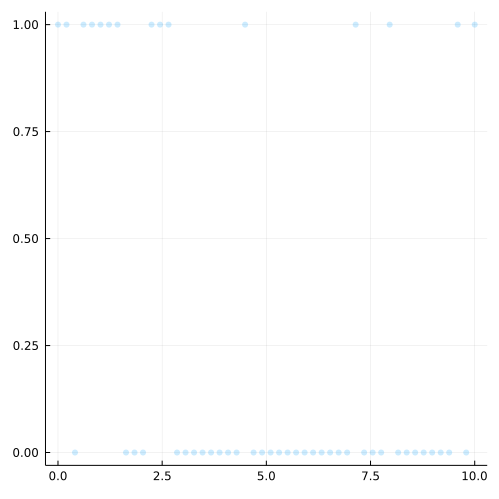

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.958843 seconds (1.82 M allocations: 103.790 MiB, 99.52% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.041268309294645, 1.0548118200263756, 1.0572971974671537, 1.0424278139333263, 1.006204991418372, 0.948944420194941, 0.8750343113641047, 0.7923264356203119, 0.7111851867128914, 0.6442409260001554  …  1.262661967615351, 1.2814770648940526, 1.277412951747259, 1.2407066217521232, 1.1684909568358386, 1.0668354613981665, 0.951389025078652, 0.8458087284156769, 0.7760067160935195, 0.7566835102375178], θ = [0.22961867843179534, 0.2291383401823306, 0.22904978666205023, 0.22957770265134017, 0.23084441587131294, 0.2327879675095708, 0.23518180939349903, 0.23769324680184137, 0.23996983208734315, 0.24169761846201088  …  0.221345076883272, 0.22060566544155888, 0.22076579184101788, 0.2222015932121501, 0.2249672017035686, 0.22870878522363847, 0.2327065275466125, 0.2360902441318019, 0.23816653712295868, 

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:42
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:24
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:36
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:12
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:57
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:47
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:25
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.5432766146893095, -0.2978495080798188, -0.11488605324004653, -0.027548422303420694, -0.06390550532940242, -0.1497281126081179, -0.3752710997876135, -0.5829291386802686, -0.7788882615654813, -0.936899647306841  …  -0.42038572014529463, -0.4705397737411412, -0.5541752773374239, -0.6415907044345757, -0.752321207954209, -0.8245563227389971, -0.8694950853331491, -0.8169141675711997, -0.7134022533103693, -0.4760927394735382]]
 [[2.7377239711799204, 2.5944990956790313, 2.2524666467555705, 1.8410639596204659, 1.3059182509385114, 0.8110932527368723, 0.2888056294111724, -0.1248773182174292, -0.4107045980426009, -0.5940159950257388  …  -0.5121516984688479, -0.4373073628093692, -0.3992072674508932, -0.4454410307554027, -0.4719928180101899, -0.47348695873368896, -0.43832670634021625, -0.31083539083506134, -0.11377620830029689, 0.09587543780112498]]
 [[0.8538786594401091, 1.210033956874536, 1.4670279634914674, 1.590767602479321, 1.5449353749377819,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

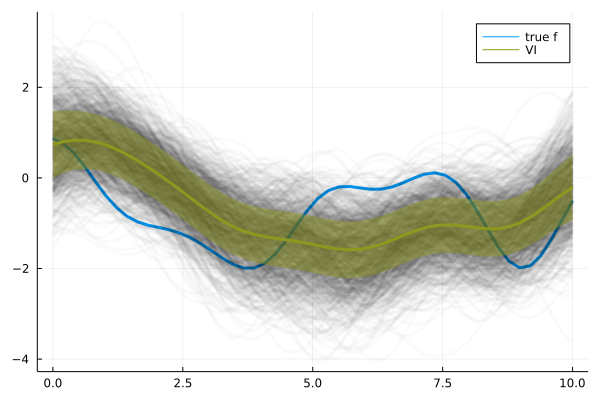

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

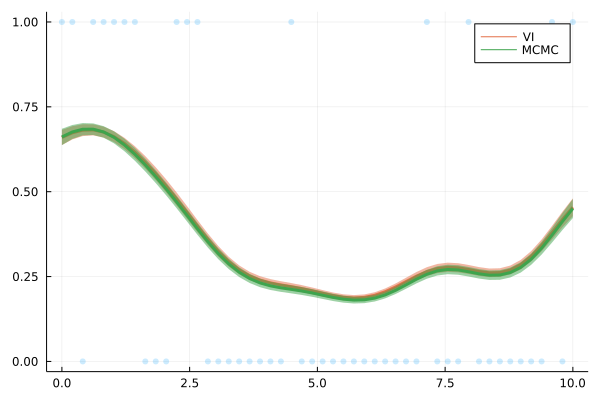

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*